I have already done Grid Search for Hyperparameter Tuning of Random Forest Classifier, so there is no particular reason for doing Bayesian Optimization as well. However, I still want to test it out to see how close the Hyperparameters tuned by both of these processes are.

The next classification algorithm I'm going to use is GradientBoosting, and doing a Grid Search (with Cross Validation) for GB is not an option - the time taken would be too high. So, I want to get a ballpark figure of the hyperparameters through Bayesian Optimization or Random Search (if BO results don't look good from this notebook), and then probably do a smaller Grid Search in that ballpark - at least that is the idea.

In [1]:
import pathlib
import numpy as np
import pandas as pd
from scipy import sparse
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from bayes_opt import BayesianOptimization
import loggingScoring as ls
import matplotlib.pyplot as plt
import seaborn as sns

### Initiating Logging

In [2]:
log = ls.get_logfile('3-1.log')
log.info('Random Forest Classifier - Hyperparameter Tuning with Bayesian Optimization')

### Load Data

In [3]:
datapath = pathlib.Path('..') / 'Data'
data_loader = np.load(datapath / 'PreprocessedData.npz')
X_train = sparse.csr_matrix((data_loader['X_train_data'],
                             data_loader['X_train_indices'],
                             data_loader['X_train_indptr']),
                            shape = data_loader['X_train_shape'])
y_train = data_loader['y_train']
X_test = sparse.csr_matrix((data_loader['X_test_data'],
                            data_loader['X_test_indices'],
                            data_loader['X_test_indptr']),
                           shape = data_loader['X_test_shape'])
y_test = data_loader['y_test']

### Model

In [4]:
default_params = RandomForestClassifier().get_params()
print('Default Parameters of RandomForestClassifier :\n{}'.format(default_params))

Default Parameters of RandomForestClassifier :
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


Fit time: 7.008 s / Predict time: 0.099 s ---- Precision: 0.917 / Recall: 0.964 / Accuracy: 0.941

Classification Report :

              precision    recall  f1-score   support

        Real       0.96      0.92      0.94      3187
        Fake       0.92      0.96      0.94      2936

    accuracy                           0.94      6123
   macro avg       0.94      0.94      0.94      6123
weighted avg       0.94      0.94      0.94      6123

ROC AUC Score : 0.9414578789513597


Confusion Matrix :



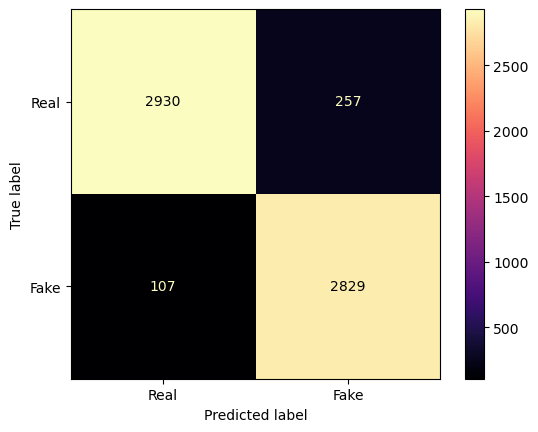

In [5]:
rf = RandomForestClassifier(n_jobs = -1, random_state = 76)

start = time.time()
rf_model = rf.fit(X_train, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = rf_model.predict(X_test)
end = time.time()
pred_time = (end - start)

ls.test_results(y_test, y_pred, fit_time, pred_time)

In [6]:
new_params = rf_model.get_params()
del new_params['random_state'], new_params['n_jobs'], default_params['random_state'], default_params['n_jobs']
# since we are manually setting random_state & n-Jobs, removing those from comparison
if (default_params == new_params):
    print('No change observed in the Default Random Forest Classifier',\
                                    'parameters after fitting the data.')
else:
    print('Default Random Forest Classifier changed following parameters after fitting :')
    for key, value in default_params.items():
        if(value != new_params[key]):
            print('{} : {}'.format(key, new_params[key]))

No change observed in the Default Random Forest Classifier parameters after fitting the data.


### Hyperparameter Tuning

This is my first attempt of using Bayesian Optimization, the [documentation](https://github.com/bayesian-optimization/BayesianOptimization) page has been a big help.

The default value for max_features parameter in Random Forest Classifier is sqrt, meaning each tree in the Random Forest can use maximum sqrt(features in original training set) features. sqrt and log2 are most commonly used, however, a random float can be used as well - which would restrict maximum features to (that float * features in original training set). Of course, we can use all original features for all the trees as well - but with 35003 features in the training set, that may not be a very wise decision.

In [7]:
feat_count_train = X_train.shape[1]
print('Max Features')
print(f'Number of Features in Train and Test Set : {feat_count_train}')
sqrt_max_features = int(np.sqrt(feat_count_train))
log2_max_features = int(np.log2(feat_count_train))
print(f'SQRT can use maximum {sqrt_max_features} features for each tree,' +\
        f' which comes out to be {round(sqrt_max_features / feat_count_train, 5)} times original features.')
print(f'LOG2 can use maximum {log2_max_features} features for each tree,' +\
        f' which comes out to be {round(log2_max_features / feat_count_train, 5)} times original features.')

Max Features
Number of Features in Train and Test Set : 35003
SQRT can use maximum 187 features for each tree, which comes out to be 0.00534 times original features.
LOG2 can use maximum 15 features for each tree, which comes out to be 0.00043 times original features.


I don't want to attempt anything drastic, but it would be worth trying a few other max_feature values. Specially since Bayesian Optimization allows exploring a range, I would like to explore the 0 to 0.008 (roughly 1.5 times the sqrt value) range. I will actually provide the range in integers (as in number of features) - which will roughly translate into 1 to 280 features.

In [8]:
# function for Bayesian Optimization to maximize
def classifier_crossval_function(n_estimators, max_depth, max_features, min_samples_leaf):
    '''
        this is the function the optimizer will call
        the inputs for this function will be provided by the optimizer
        the inputs are basically the parameters within the range that we have provided
        the inputs can be (and mostly are) floats, if classifier requires discrete (int) values - they need to be adjusted
        the function will have to modify the inputs as per the requirements of the classifier
        then the classifer instance is instantiated with these provided parameters
        and cross validated on training dataset
        the return of the function is the mean score of the cross validation
        the Bayesian Optimizer will basically try to maximize this mean score
    '''
    
    print(f'Raw Parameters : {n_estimators = }, {max_depth = }, {max_features = }, {min_samples_leaf = }.')
    
    # modify float to int. in case of max_depth (range 25 to 300), values above 250 will be considered as None
    n_estimators = round(n_estimators)
    if max_depth > 250:
        max_depth = None
    else:
        max_depth = round(max_depth)
    max_features = round(max_features)
    min_samples_leaf = round(min_samples_leaf)
    
    print(f'Changed Parameters : {n_estimators = }, {max_depth = }, {max_features = }, {min_samples_leaf = }.')
    
    rf_cv = RandomForestClassifier(n_estimators = n_estimators,
                                   max_depth = max_depth,
                                   max_features = max_features,
                                   min_samples_leaf = min_samples_leaf,
                                   n_jobs = -1,
                                   random_state = 76)
    skf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 76)
    
    scores = cross_val_score(estimator = rf_cv,
                             X = X_train,
                             y = y_train,
                             scoring = 'accuracy',
                             cv = skf,
                             verbose = 0)
    mean_score = scores.mean()
    
    print(f'Score : {mean_score}.')
    return mean_score

In [9]:
params_limit = {
    'n_estimators': (50, 1000),
    'max_depth': (25, 300), # values larger than 250 will be encoded as None
    'max_features' : (1, 280),
    # this is actually the per tree feature count, will be converted into int - diff from what we used in Grid Search
    'min_samples_leaf' : (1, 7)
}

bo = BayesianOptimization(f = classifier_crossval_function,
                          pbounds = params_limit,
                          random_state = 76,
                          verbose = 1)

In [10]:
# maximizing classifier_crossval_function
# diverting output to log
ls.divert_stdOut2log(log)
bo.maximize(init_points = 7, n_iter = 50)
ls.revert_log2stdOut()

In [11]:
# the maximum target value, and corresponding parameters
bo.max

{'target': 0.9442588170519427,
 'params': {'max_depth': 257.5244075666551,
  'max_features': 13.439853697091113,
  'min_samples_leaf': 1.4593180472928535,
  'n_estimators': 595.2838418980377}}

In [12]:
# visualizing the parameter space
target_values = np.array([res['target'] for res in bo.res])
params_max_depth_values = np.array([round(res['params']['max_depth']) for res in bo.res])
params_max_features_values = np.array([round(res['params']['max_features']) for res in bo.res])
params_min_samples_leaf_values = np.array([round(res['params']['min_samples_leaf']) for res in bo.res])
params_n_estimators_values = np.array([round(res['params']['n_estimators']) for res in bo.res])

Now, I want to compare the best parameters found using Grid Search and Bayesian Optimization through visualization. Just going by the numbers -
1) max_depth : Above 250 is considered as None in both cases, and that's where the best max_depth value falls in both search methods.
2) max_features : Best value for this parameter according to our Grid Search is log2, which comes out as 15 maximum features for each tree. In Bayesian Optimization, the best value is provided as 13.44, which after rounding comes out as 13.
3) min_samples_leaf : According to both search methods, best value for this parameter is 1 (after rounding off 1.46 in Bayesian Optimization).
4) n_estimators : This is where the bast value differs a bit - according to Grid Search the best value is 400 trees, whereas as per Bayesian Optimization the best value is 595 trees (rounded off).

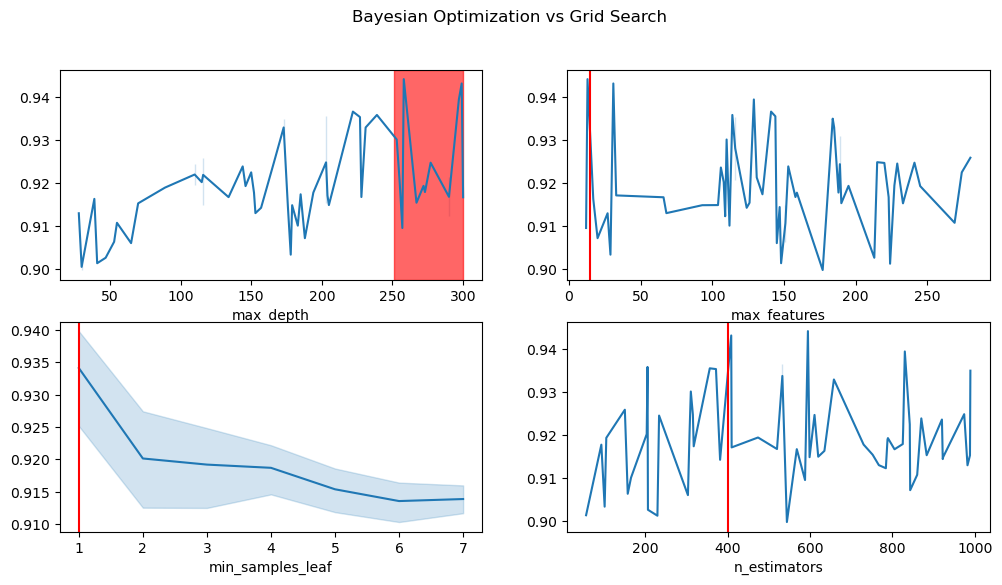

In [13]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 6))
sns.lineplot(x = params_max_depth_values, y = target_values, ax = axes[0, 0])
axes[0, 0].set(xlabel = 'max_depth')
axes[0, 0].axvspan(xmin = 251, xmax = 300, color = 'r', alpha = 0.6)
sns.lineplot(x = params_max_features_values, y = target_values, ax = axes[0, 1])
axes[0, 1].set(xlabel = 'max_features')
axes[0, 1].axvline(15, color = 'r')
sns.lineplot(x = params_min_samples_leaf_values, y = target_values, ax = axes[1, 0])
axes[1, 0].set(xlabel = 'min_samples_leaf')
axes[1, 0].axvline(1, color = 'r')
sns.lineplot(x = params_n_estimators_values, y = target_values, ax = axes[1, 1])
axes[1, 1].set(xlabel = 'n_estimators')
axes[1, 1].axvline(400, color = 'r')
fig.suptitle('Bayesian Optimization vs Grid Search')
plt.show()
plt.close()

OK, so regarding the only differing parameter - n_estimators, Bayesian Optimization also saw a peak at around 400 (where the peak is according to Grid Search), but the peak around 600 (595) is slightly higher. This looks good - Bayesian Optimization was able to find out results very close to Grid Search, and that took a lot less time. I can use this in the next notebook (Gradient Boosting).

### Best Model
I'll now evaluate the best Bayesian Model (the bo.max one), however the best model found by Grid Search will officially remain  our best RF model, since their cross validation scores (on Training set) are quite close - I just want to see how much they differ.

Fit time: 41.018 s / Predict time: 0.801 s ---- Precision: 0.917 / Recall: 0.964 / Accuracy: 0.941

Classification Report :

              precision    recall  f1-score   support

        Real       0.96      0.92      0.94      3187
        Fake       0.92      0.96      0.94      2936

    accuracy                           0.94      6123
   macro avg       0.94      0.94      0.94      6123
weighted avg       0.94      0.94      0.94      6123

ROC AUC Score : 0.9414578789513597


Confusion Matrix :



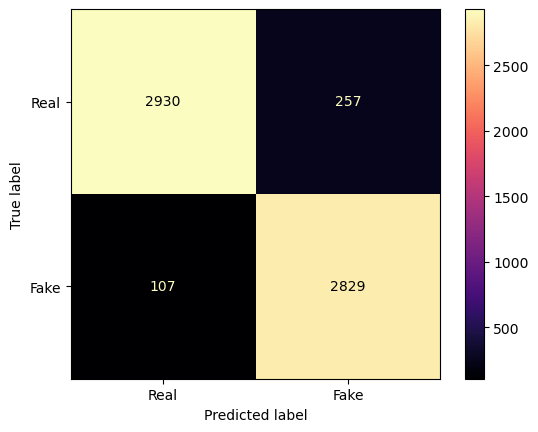

In [14]:
rf_best = RandomForestClassifier(max_depth = None,
                                 n_estimators = 595,
                                 max_features = 13,
                                 min_samples_leaf = 1,
                                 random_state = 76,
                                 n_jobs = -1)

start = time.time()
rf_model_best = rf_best.fit(X_train, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred_best = rf_model_best.predict(X_test)
end = time.time()
pred_time = (end - start)

ls.test_results(y_test, y_pred_best, fit_time, pred_time)

As expected, this model's performance is identical.